In [1]:
import pickle
import pandas as pd
import os
import seaborn
import matplotlib.pyplot as plt


# Load the ssem data
simulation_name = "SEP2"

with open(f"../figures/scenario-properties-{simulation_name}.pkl", "rb") as f:
    scenario_properties = pickle.load(f)

# Quick check: What attributes are available?
print(dir(scenario_properties))
# Define base output path
base_path = f"../figures/{simulation_name}"
os.makedirs(base_path, exist_ok=True)

# load the MOCAT-MC data
mc_launch = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv'
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


['Dhl', 'Dhu', 'FLM_steps', 'HMid', 'LC', 'R0', 'R0_km', 'R0_rad_km', 'SEP_mapping', 'V', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'add_collision_pairs', 'add_species_set', 'all_symbolic_vars', 'baseline', 'build_indicator_variables', 'build_model', 'build_model_elliptical', 'build_sym_model', 'calculate_scen_times_dates', 'coll_eqs_lambd', 'collision_pairs', 'cum_CSI', 'debris_length', 'debris_names', 'deltaH', 'density_model', 'drag_term_cur', 'drag_term_upper', 'end_date', 'equations', 'fragment_spreading', 'full_Cdot_PMD', 'full_coll', 'full_drag', 'full_lambda', 'full_lambda_flattened', 'future_launch_model', 'indicator_results', 'indicator_variables', 'indicator_variables_list', 'in

In [2]:
mc_pop_time = pd.read_csv(mc_pop_time_path)

# Launch

S_total sum: 65927.0
Su_total sum: 5040
Sns_total sum: 11380
B_total sum: 1171
Overall total: 83518.0


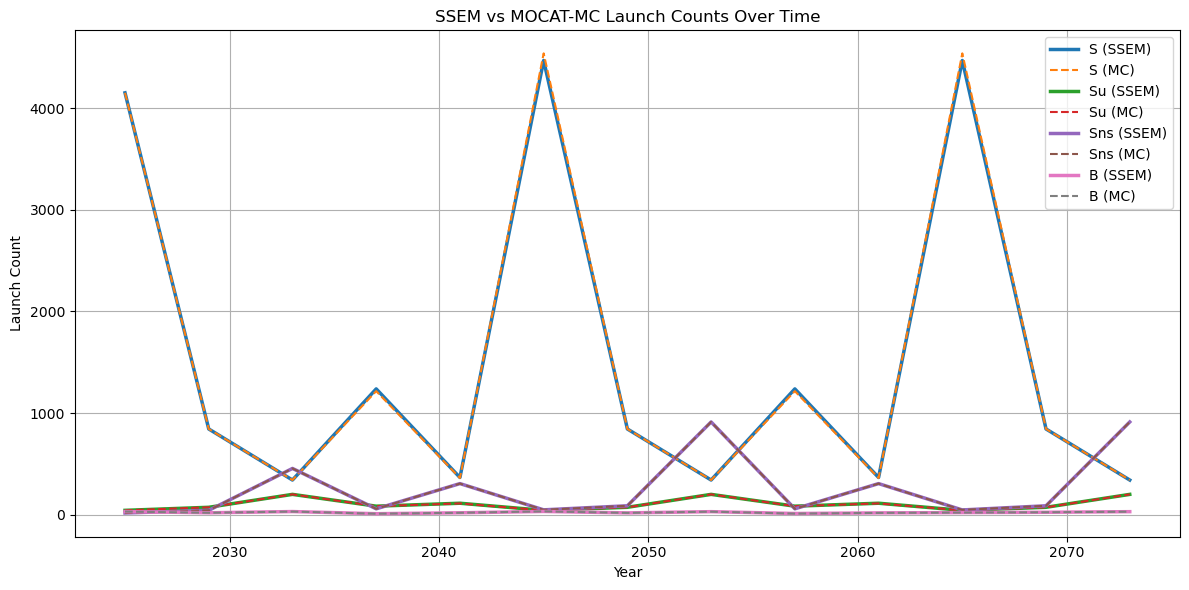

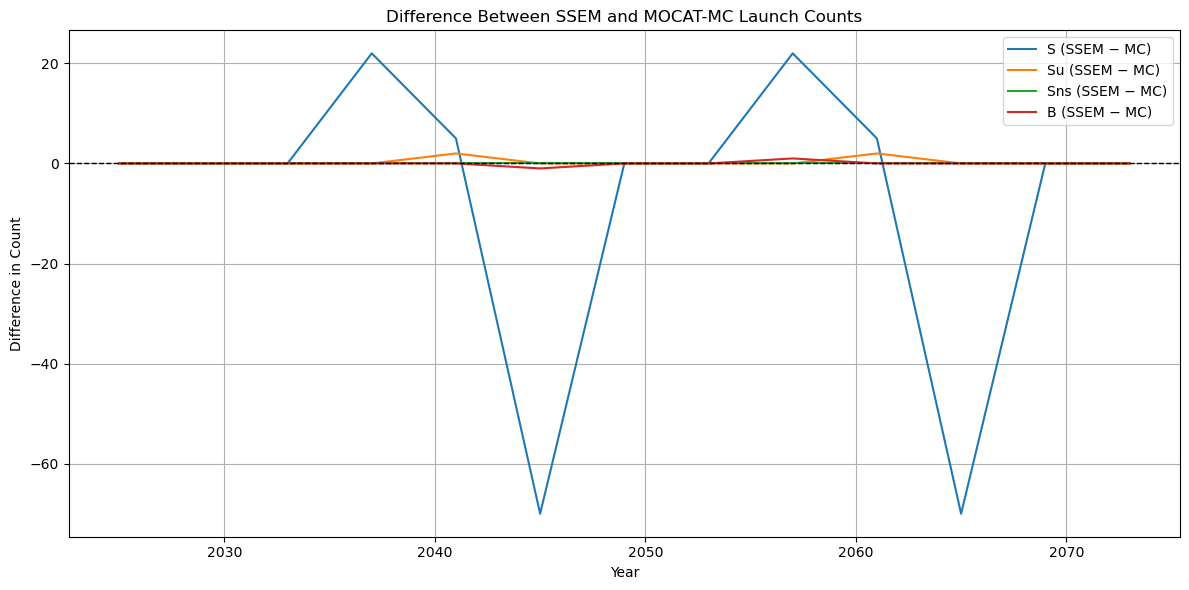

🧮 Final cumulative difference for S: -86
🧮 Final cumulative difference for Su: +4
🧮 Final cumulative difference for Sns: +0
🧮 Final cumulative difference for B: +0


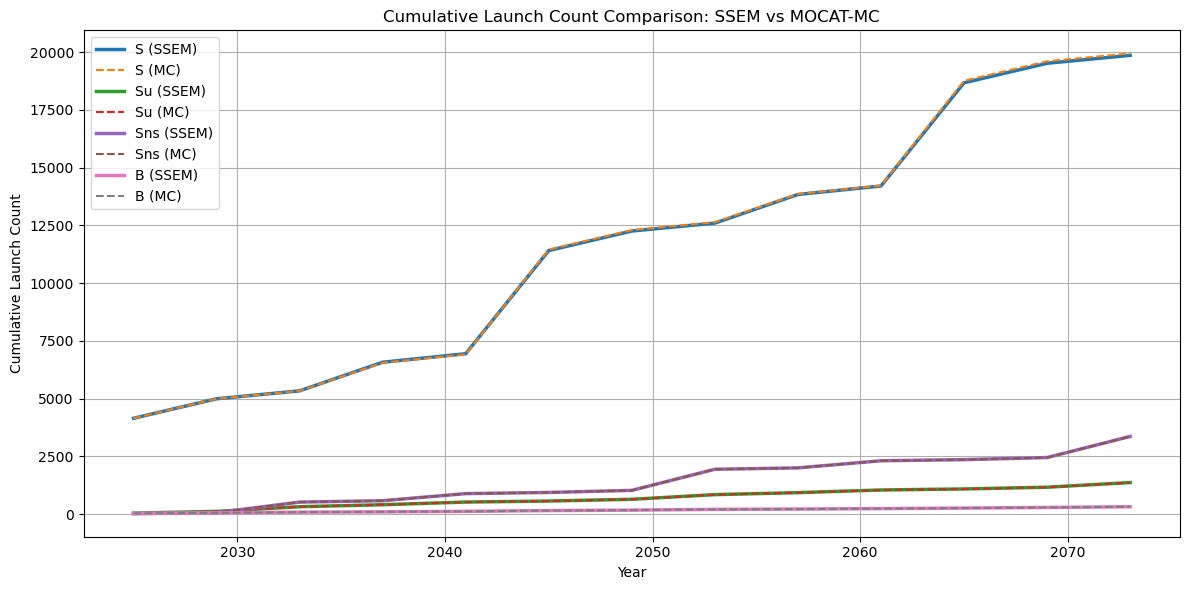

In [3]:
### MOCAT-pySSEM
df = scenario_properties.FLM_steps
# Load your DataFrame
df['epoch_start_date'] = pd.to_datetime(df['epoch_start_date'])

# Sum across all alt_bin values (i.e., group by epoch_start_date)
grouped = df.groupby('epoch_start_date').sum(numeric_only=True)

# Identify species columns of interest
s_cols   = [col for col in grouped.columns if col.startswith('S_')]
su_cols  = [col for col in grouped.columns if col.startswith('Su_')]
sns_cols = [col for col in grouped.columns if col.startswith('Sns')]
b_cols = [col for col in grouped.columns if col.startswith('B')]

# Sum within each category
grouped['S_total']   = grouped[s_cols].sum(axis=1)
grouped['Su_total']  = grouped[su_cols].sum(axis=1)
grouped['Sns_total'] = grouped[sns_cols].sum(axis=1)
grouped['B_total'] = grouped[b_cols].sum(axis=1)

print("S_total sum:", grouped['S_total'].sum())
print("Su_total sum:", grouped['Su_total'].sum())
print("Sns_total sum:", grouped['Sns_total'].sum())
print("B_total sum:", grouped['B_total'].sum())
print("Overall total:", grouped[['S_total', 'Su_total', 'Sns_total', 'B_total']].sum().sum())

### MOCAT-MC 

df_mc = pd.read_csv(mc_launch)

# Offset MC years to actual calendar years
df_mc['Year'] = df_mc['Year'] + 2025

# Now pivot and parse to datetime
pivot_mc = df_mc.pivot(index='Year', columns='Species', values='Launch_Count').fillna(0)
pivot_mc.index = pd.to_datetime(pivot_mc.index, format='%Y')

# Convert Year to datetime for alignment
pivot_mc.index = pd.to_datetime(pivot_mc.index, format='%Y')

# === Reindex SSEM results to match MC for comparison ===
grouped_trimmed = grouped.copy()
grouped_trimmed.index = pd.to_datetime(grouped_trimmed.index)
common_years = pivot_mc.index.intersection(grouped_trimmed.index)
ssem_plot = grouped_trimmed.loc[common_years]
mc_plot = pivot_mc.loc[common_years]

# === Plot 1: Combined plot ===
plt.figure(figsize=(12, 6))
species_list = ['S', 'Su', 'Sns', 'B']
for sp in species_list:
    if f'{sp}_total' in ssem_plot.columns and sp in mc_plot.columns:
        plt.plot(ssem_plot.index, ssem_plot[f'{sp}_total'], label=f'{sp} (SSEM)', linewidth=2.5)
        plt.plot(mc_plot.index, mc_plot[sp], '--', label=f'{sp} (MC)', linewidth=1.5)

plt.title("SSEM vs MOCAT-MC Launch Counts Over Time")
plt.xlabel("Year")
plt.ylabel("Launch Count")
plt.legend()
plt.grid(True)
# plt.yscale("log")
plt.tight_layout()
plt.show()

# === Plot 2: Difference Plot (SSEM - MC) ===
plt.figure(figsize=(12, 6))
for sp in species_list:
    if f'{sp}_total' in ssem_plot.columns and sp in mc_plot.columns:
        difference = ssem_plot[f'{sp}_total'] - mc_plot[sp]
        plt.plot(common_years, difference, label=f"{sp} (SSEM − MC)")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Difference Between SSEM and MOCAT-MC Launch Counts")
plt.xlabel("Year")
plt.ylabel("Difference in Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Cumulative Launch Counts ===
plt.figure(figsize=(12, 6))
for sp in species_list:
    if f'{sp}_total' in ssem_plot.columns and sp in mc_plot.columns:
        ssem_cumsum = ssem_plot[f'{sp}_total'].cumsum()
        mc_cumsum = mc_plot[sp].cumsum()

        plt.plot(ssem_plot.index, ssem_cumsum, label=f'{sp} (SSEM)', linewidth=2.5)
        plt.plot(mc_plot.index, mc_cumsum, '--', label=f'{sp} (MC)', linewidth=1.5)

        # Print final cumulative difference
        final_diff = ssem_cumsum.iloc[-1] - mc_cumsum.iloc[-1]
        print(f"🧮 Final cumulative difference for {sp}: {final_diff:+,.0f}")

plt.title("Cumulative Launch Count Comparison: SSEM vs MOCAT-MC")
plt.xlabel("Year")
plt.ylabel("Cumulative Launch Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Total Population Over Time

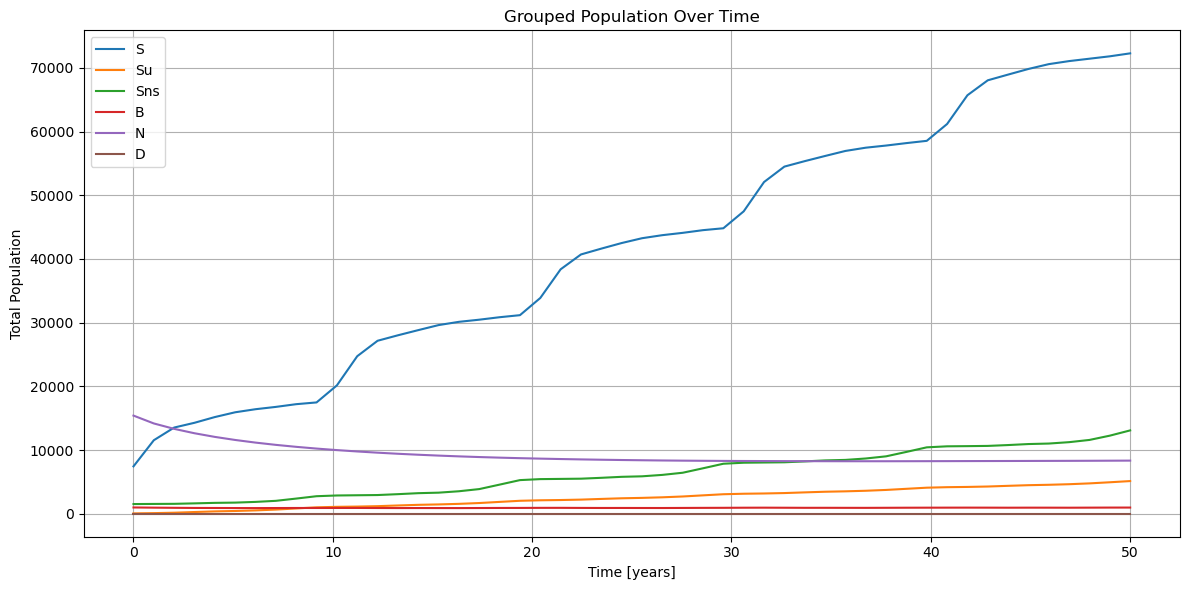

Saved population data to ../figures/SEP2/pop_time.csv


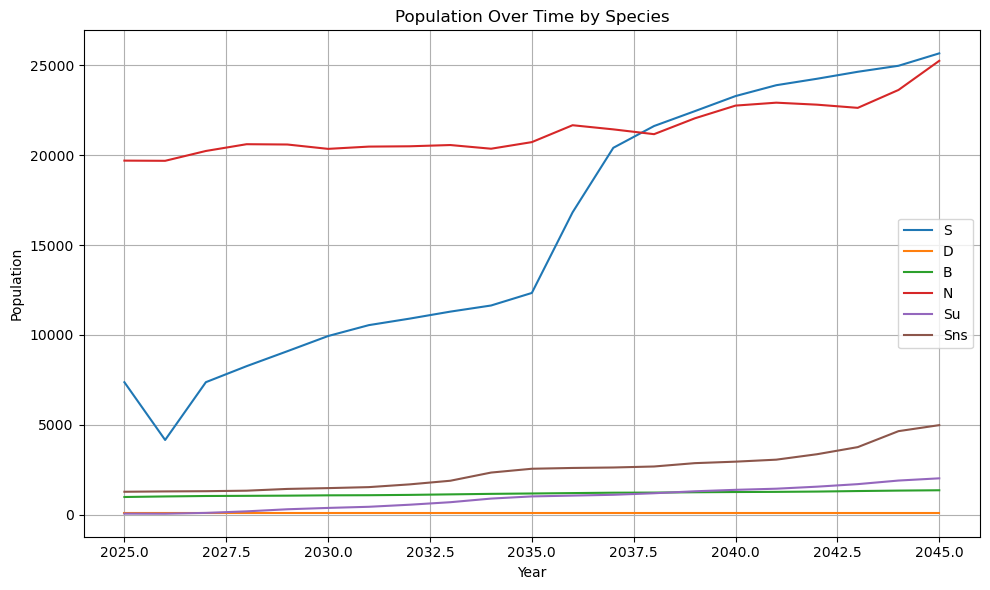

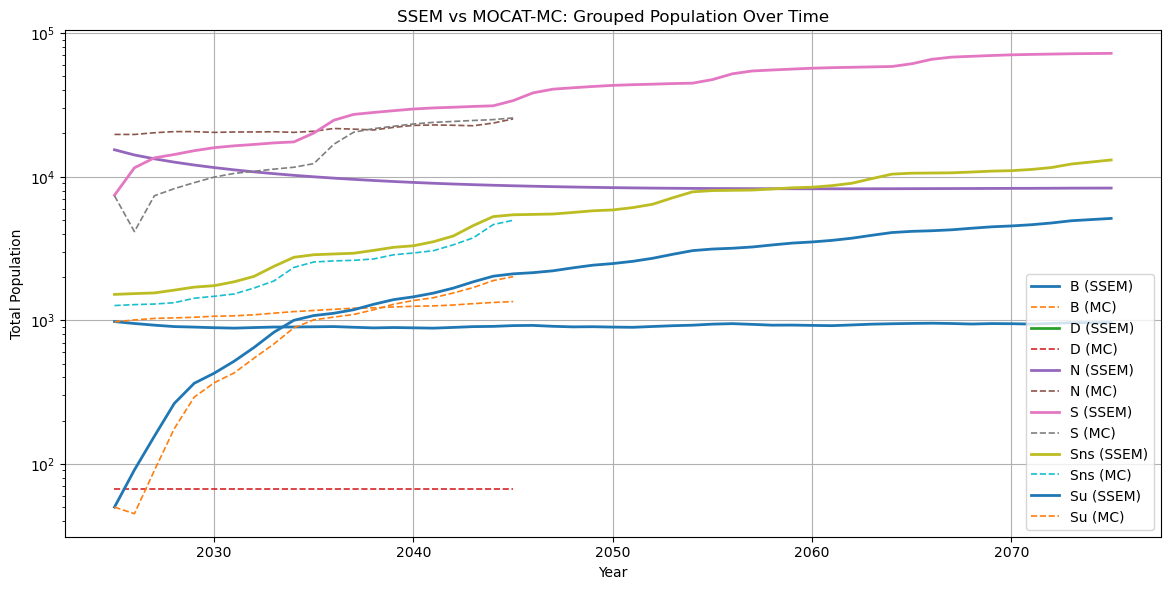

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Time array (seconds → years)
times = scenario_properties.scen_times
species = scenario_properties.species_names
n_shells = scenario_properties.n_shells
y = scenario_properties.output.y

# Define fragment mass species for D group
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']

# Initialize grouped data
group_pop = {
    'S': np.zeros_like(times),
    'Su': np.zeros_like(times),
    'Sns': np.zeros_like(times),
    'B': np.zeros_like(times),
    'N': np.zeros_like(times),
    'D': np.zeros_like(times)
}

# Classify each species
for i, sp in enumerate(species):
    start = i * n_shells
    end = (i + 1) * n_shells
    pop_total = y[start:end, :].sum(axis=0)

    if sp.startswith('Sns'):
        group_pop['Sns'] += pop_total
    elif sp.startswith('Su'):
        group_pop['Su'] += pop_total
    elif sp.startswith('S'):
        group_pop['S'] += pop_total
    elif sp == 'B':
        group_pop['B'] += pop_total
    elif sp in large_fragments:
        group_pop['D'] += pop_total
    elif sp.startswith('N'):
        group_pop['N'] += pop_total
    # else: ignore

# Plotting
plt.figure(figsize=(12, 6))
for group, pop in group_pop.items():
    plt.plot(times, pop, label=group)

plt.xlabel("Time [years]")
plt.ylabel("Total Population")
plt.title("Grouped Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

import pandas as pd

# Convert start_date to datetime if it's a string
start_year = pd.to_datetime(scenario_properties.start_date).year

# Build tidy DataFrame
rows = []
for species, pop_series in group_pop.items():
    for t_idx, pop in enumerate(pop_series):
        year = int(start_year + times[t_idx])
        rows.append({
            "Species": species,
            "Population": pop,
            "Year": year
        })

# Create DataFrame
df_grouped = pd.DataFrame(rows)

# Optional: sort by year and species
df_grouped = df_grouped.sort_values(["Species", "Year"]).reset_index(drop=True)

# Save grouped population DataFrame to CSV
csv_path = os.path.join(base_path, "pop_time.csv")
df_grouped.to_csv(csv_path, index=False)

print(f"Saved population data to {csv_path}")

# MC

mc_pop_time = pd.read_csv(mc_pop_time_path)

plt.figure(figsize=(10, 6))
for species in mc_pop_time["Species"].unique():
    species_df = mc_pop_time[mc_pop_time["Species"] == species]
    plt.plot(species_df["Year"], species_df["Population"], label=species)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

# === Combined Plot: SSEM vs MC ===
plt.figure(figsize=(12, 6))

for species in df_grouped["Species"].unique():
    ssem_df = df_grouped[df_grouped["Species"] == species]
    plt.plot(ssem_df["Year"], ssem_df["Population"], label=f"{species} (SSEM)", linewidth=2)

    if species in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == species]
        plt.plot(mc_df["Year"], mc_df["Population"], '--', label=f"{species} (MC)", linewidth=1.2)

plt.xlabel("Year")
plt.ylabel("Total Population")
plt.title("SSEM vs MOCAT-MC: Grouped Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.show()

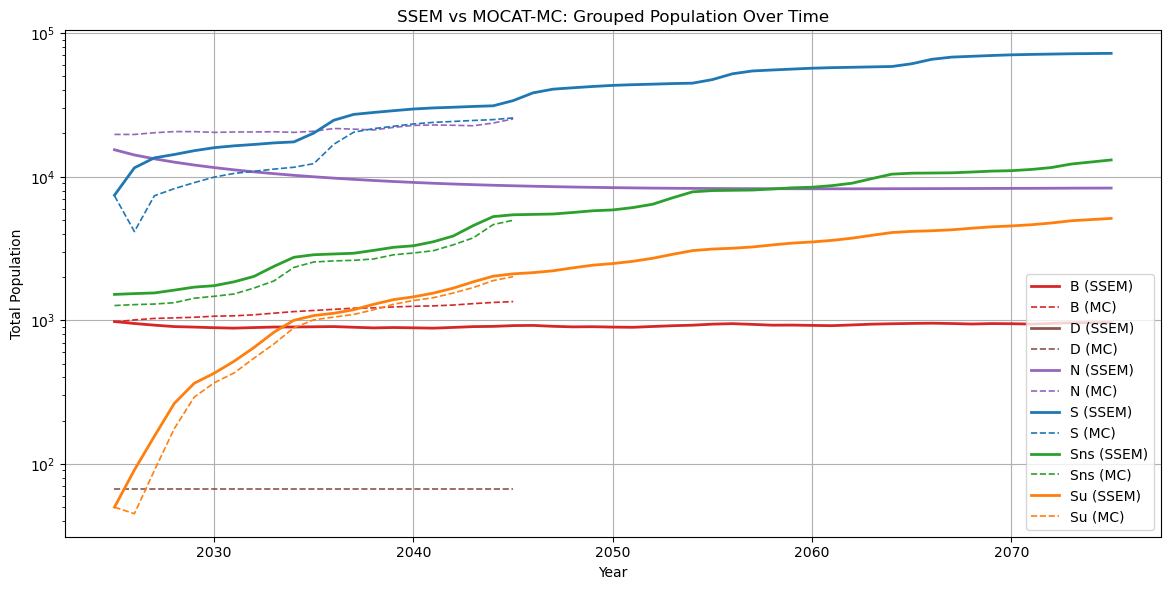

In [5]:
import matplotlib.pyplot as plt

# Standardize species names in MC data
mc_pop_time["Species"] = mc_pop_time["Species"].replace({
    "SU": "Su",
    "SNS": "Sns"
})

# Define consistent color mapping for species
color_map = {
    'S': 'tab:blue',
    'Su': 'tab:orange',
    'Sns': 'tab:green',
    'B': 'tab:red',
    'N': 'tab:purple',
    'D': 'tab:brown'
}

plt.figure(figsize=(12, 6))

for species in df_grouped["Species"].unique():
    ssem_df = df_grouped[df_grouped["Species"] == species]
    plt.plot(ssem_df["Year"], ssem_df["Population"], label=f"{species} (SSEM)",
             linewidth=2, color=color_map.get(species, None))

    if species in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == species]
        plt.plot(mc_df["Year"], mc_df["Population"], '--',
                 label=f"{species} (MC)", linewidth=1.2, color=color_map.get(species, None))

plt.xlabel("Year")
plt.ylabel("Total Population")
plt.title("SSEM vs MOCAT-MC: Grouped Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.yscale('log')
plt.show()

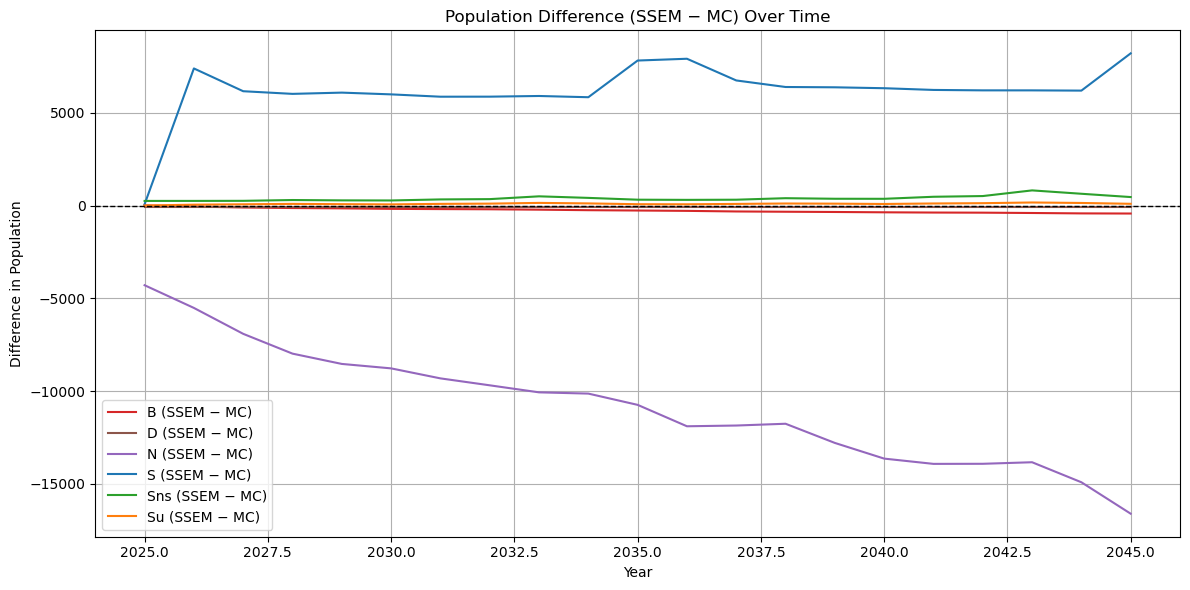

In [6]:
plt.figure(figsize=(12, 6))

# Merge for difference calculation
for species in df_grouped["Species"].unique():
    if species in mc_pop_time["Species"].unique():
        ssem_df = df_grouped[df_grouped["Species"] == species].copy()
        mc_df = mc_pop_time[mc_pop_time["Species"] == species].copy()

        merged = pd.merge(ssem_df, mc_df, on="Year", suffixes=('_ssem', '_mc'))

        merged["Diff"] = merged["Population_ssem"] - merged["Population_mc"]
        plt.plot(merged["Year"], merged["Diff"], label=f"{species} (SSEM − MC)",
                 color=color_map.get(species, None))

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Year")
plt.ylabel("Difference in Population")
plt.title("Population Difference (SSEM − MC) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
scenario_properties.FLM_steps.Sns.sum()

11380

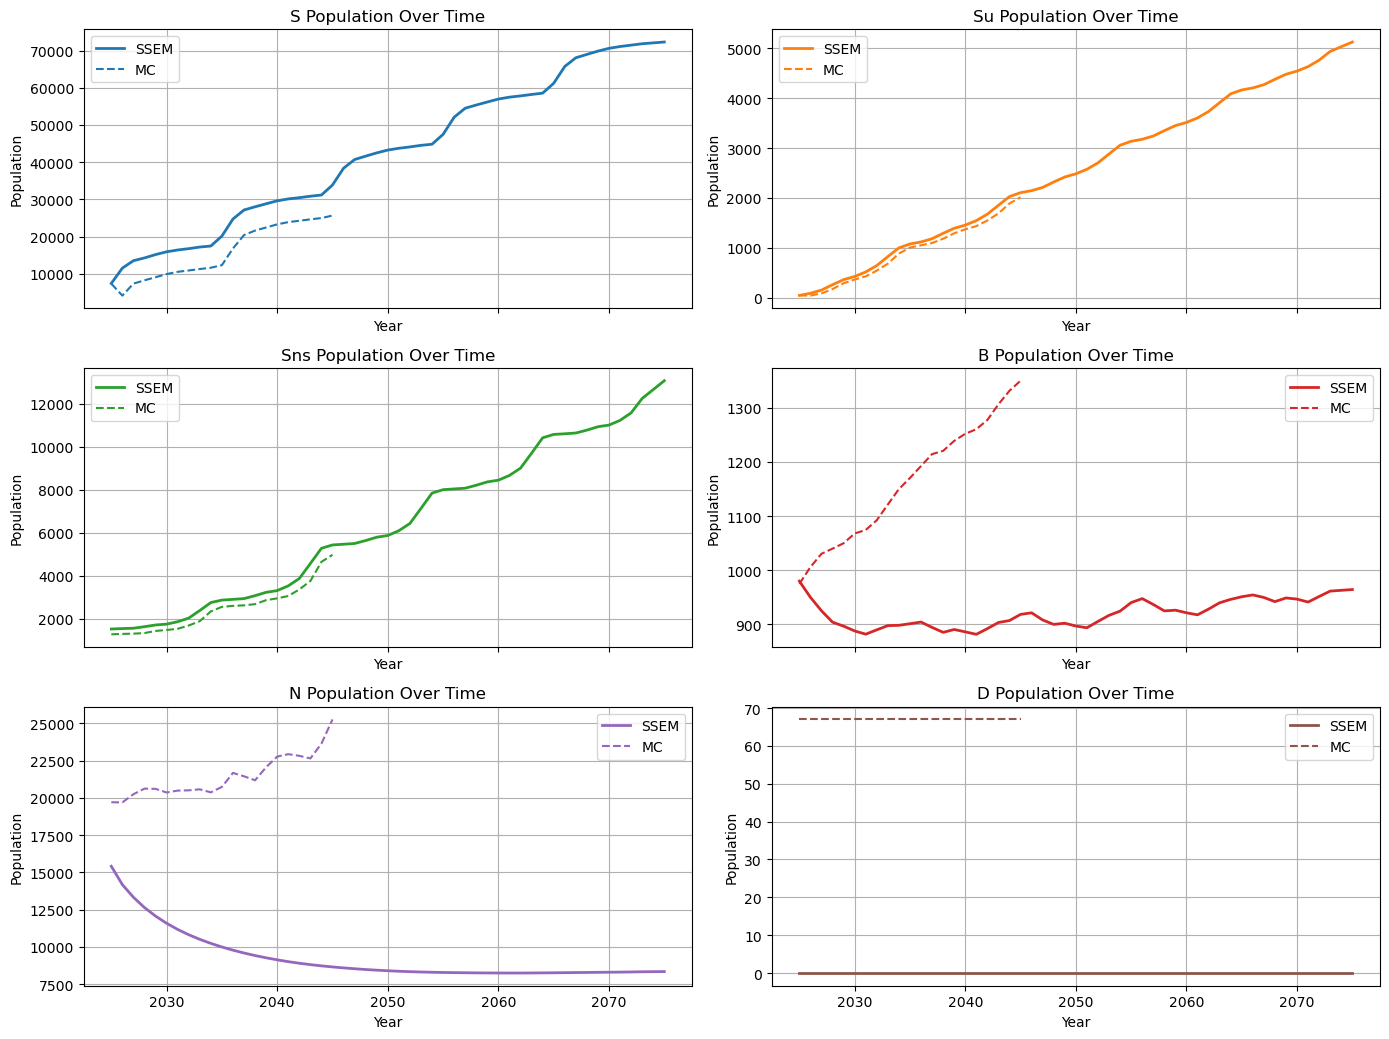

In [8]:
import matplotlib.pyplot as plt

# Standardize species names in MC data
mc_pop_time["Species"] = mc_pop_time["Species"].replace({
    "SU": "Su",
    "SNS": "Sns"
})

# Define consistent color mapping for species
color_map = {
    'S': 'tab:blue',
    'Su': 'tab:orange',
    'Sns': 'tab:green',
    'B': 'tab:red',
    'N': 'tab:purple',
    'D': 'tab:brown'
}

# List of species to plot
species_list = ['S', 'Su', 'Sns', 'B', 'N', 'D']
n_rows = (len(species_list) + 1) // 2  # adjust for layout
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows), sharex=True)

axes = axes.flatten()

for idx, species in enumerate(species_list):
    ax = axes[idx]
    
    ssem_df = df_grouped[df_grouped["Species"] == species]
    ax.plot(ssem_df["Year"], ssem_df["Population"],
            label="SSEM", color=color_map[species], linewidth=2)

    if species in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == species]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '--', label="MC", color=color_map[species], linewidth=1.5)

    ax.set_title(f"{species} Population Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(len(species_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [9]:
import numpy as np

total = sum(scenario_properties.full_lambda_flattened[-35:], np.zeros_like(scenario_properties.full_lambda_flattened[0]))
total.sum()

1169

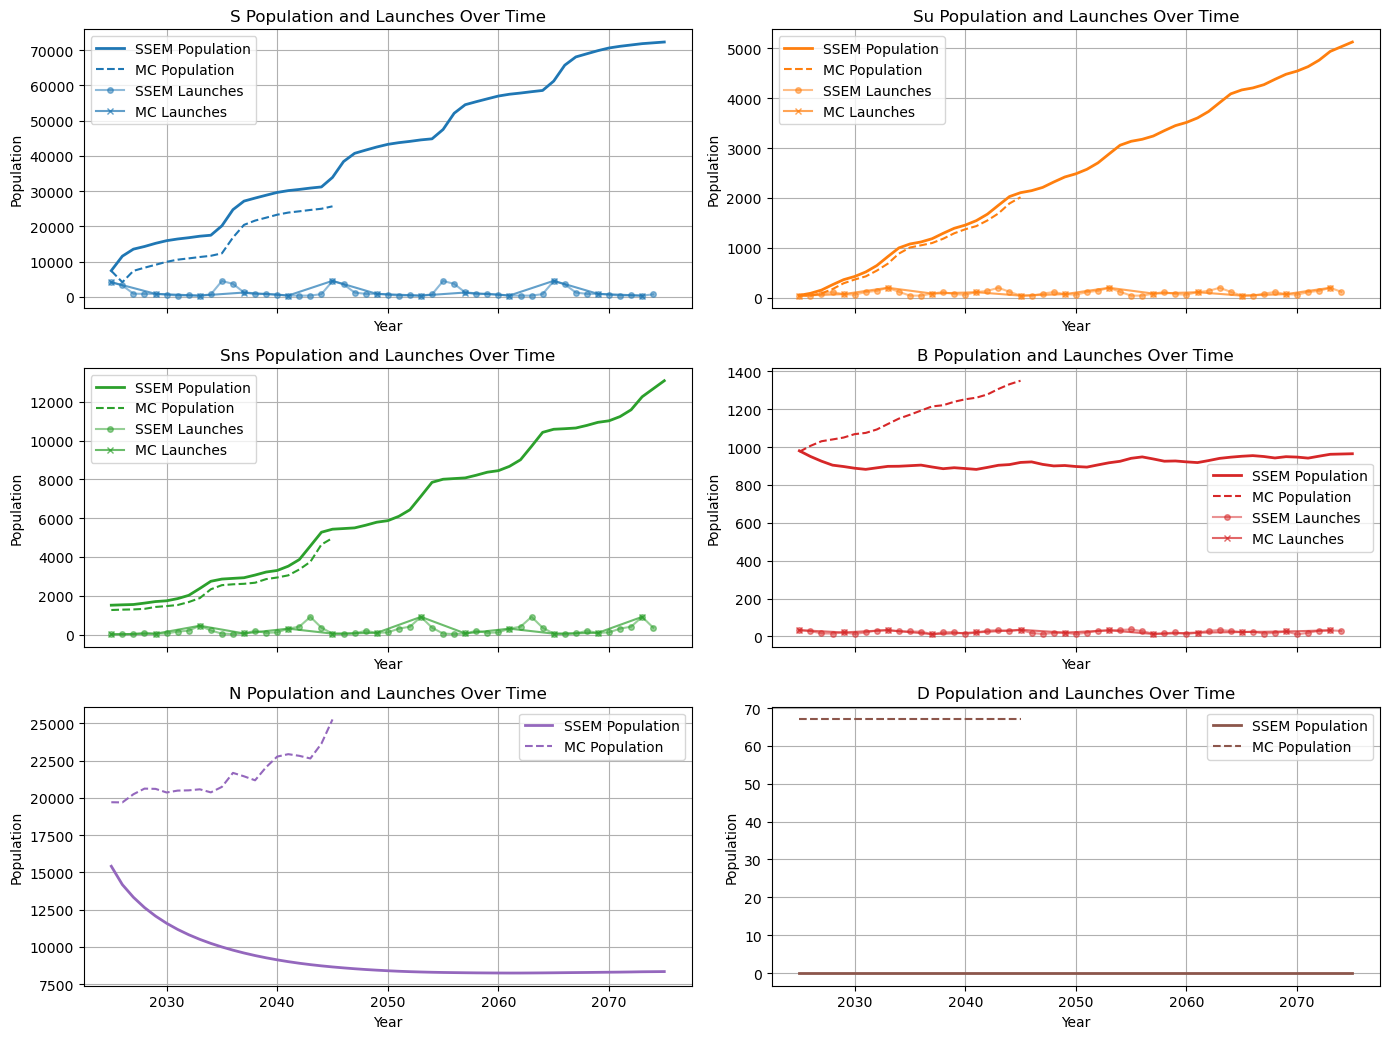

In [10]:
import matplotlib.pyplot as plt

# Standardize MC population species names
mc_pop_time["Species"] = mc_pop_time["Species"].replace({
    "SU": "Su",
    "SNS": "Sns"
})

# Define color mapping
color_map = {
    'S': 'tab:blue',
    'Su': 'tab:orange',
    'Sns': 'tab:green',
    'B': 'tab:red',
    'N': 'tab:purple',
    'D': 'tab:brown'
}

species_list = ['S', 'Su', 'Sns', 'B', 'N', 'D']
n_rows = (len(species_list) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows), sharex=True)
axes = axes.flatten()

for idx, species in enumerate(species_list):
    ax = axes[idx]

    # === Population: SSEM ===
    ssem_df = df_grouped[df_grouped["Species"] == species]
    ax.plot(ssem_df["Year"], ssem_df["Population"],
            label="SSEM Population", color=color_map[species], linewidth=2)

    # === Population: MC ===
    if species in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == species]
        ax.plot(mc_df["Year"], mc_df["Population"],
                '--', label="MC Population", color=color_map[species], linewidth=1.5)

    # === Launches: SSEM ===
    if f'{species}_total' in grouped.columns:
        ax.plot(grouped.index.year, grouped[f'{species}_total'],
                'o-', label="SSEM Launches", color=color_map[species], alpha=0.5, markersize=4)

    # === Launches: MC ===
    if species in mc_plot.columns:
        ax.plot(mc_plot.index.year, mc_plot[species],
                'x-', label="MC Launches", color=color_map[species], alpha=0.7, markersize=5)

    # === Final formatting ===
    ax.set_title(f"{species} Population and Launches Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Remove unused axes
for j in range(len(species_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

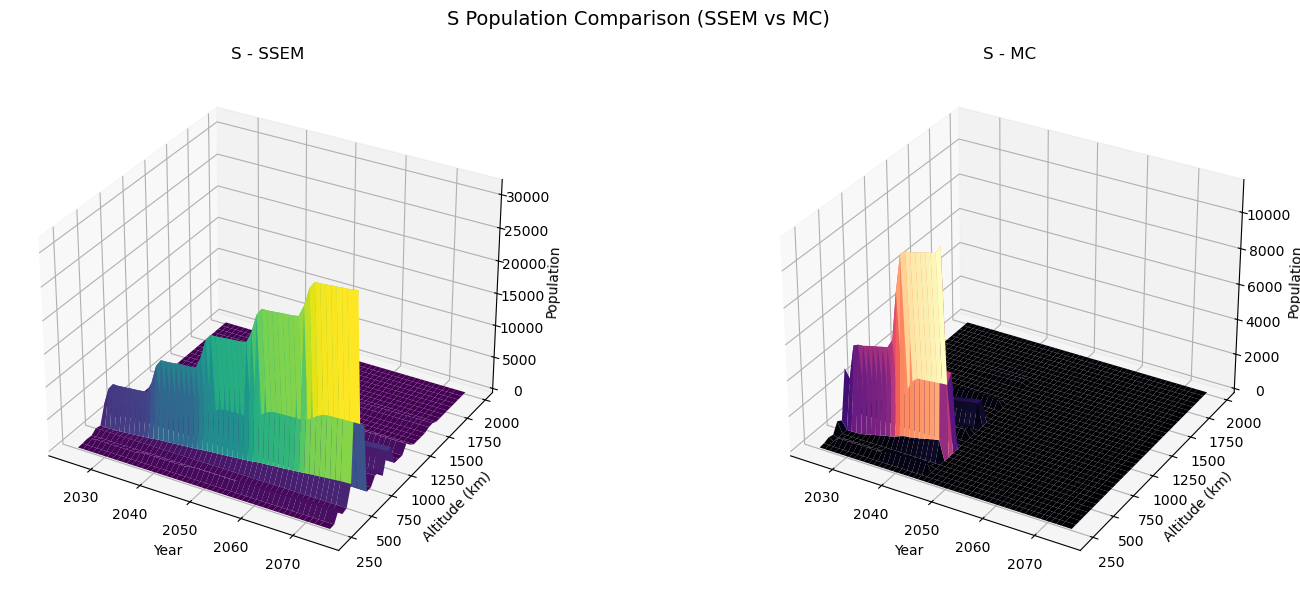

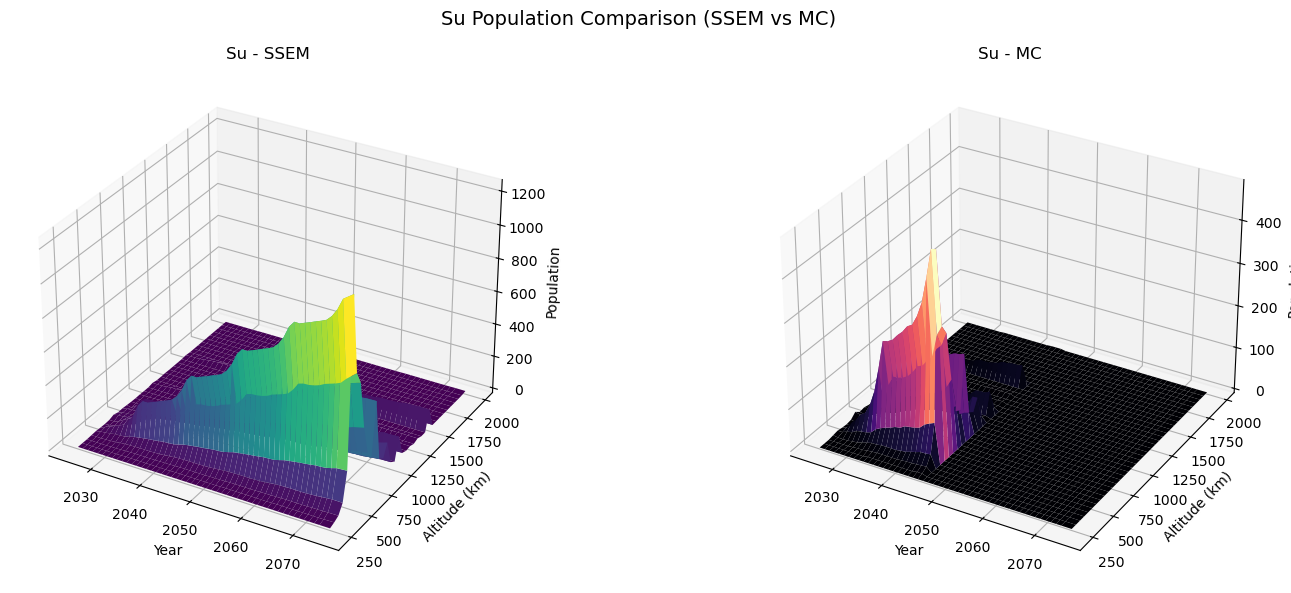

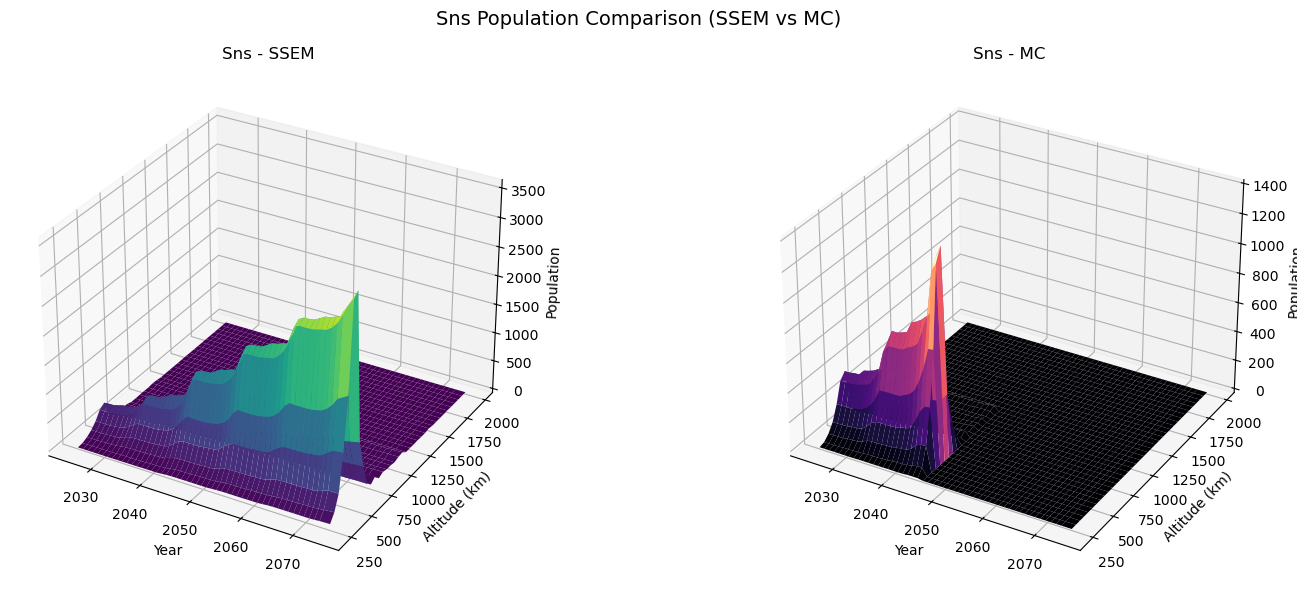

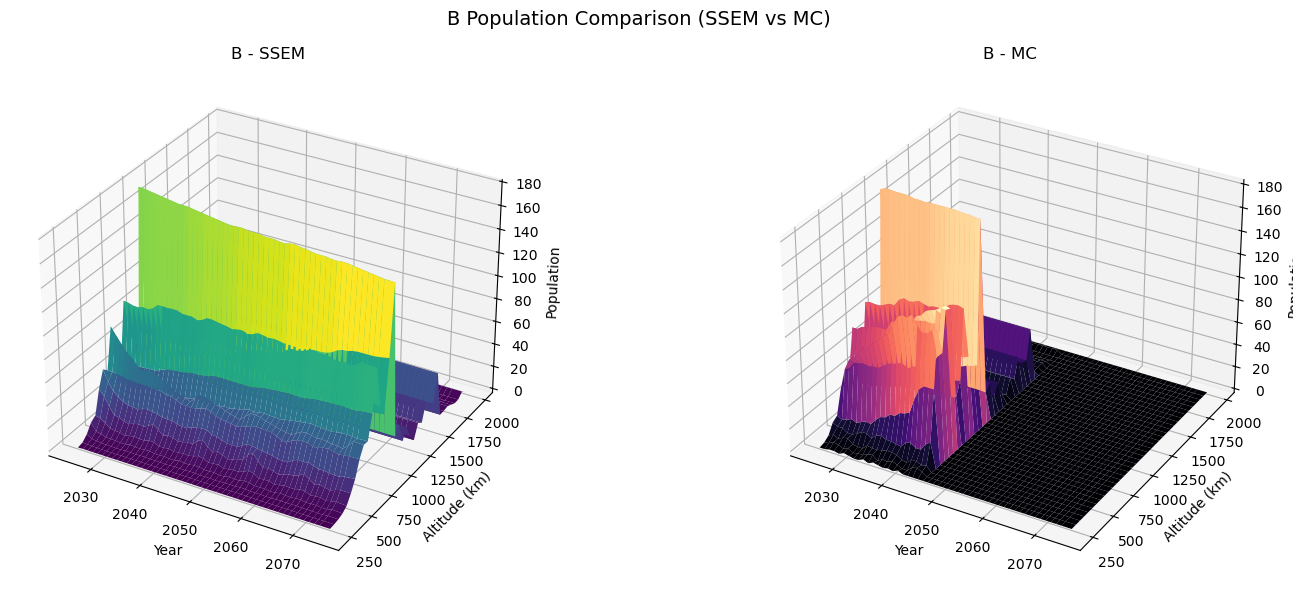

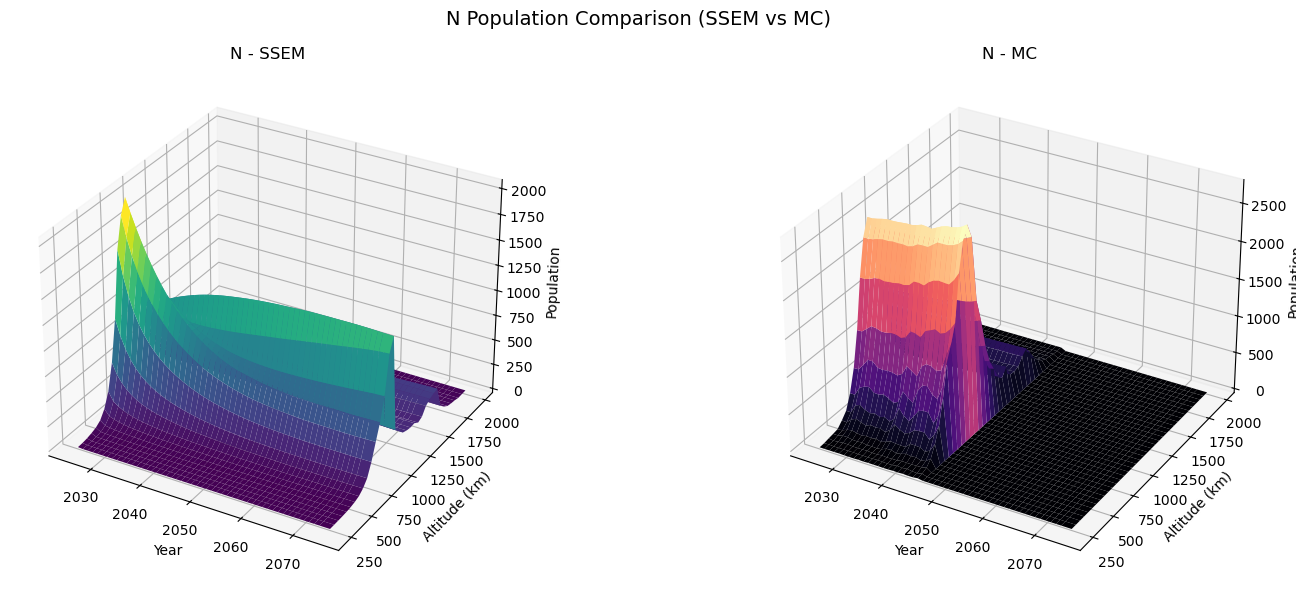

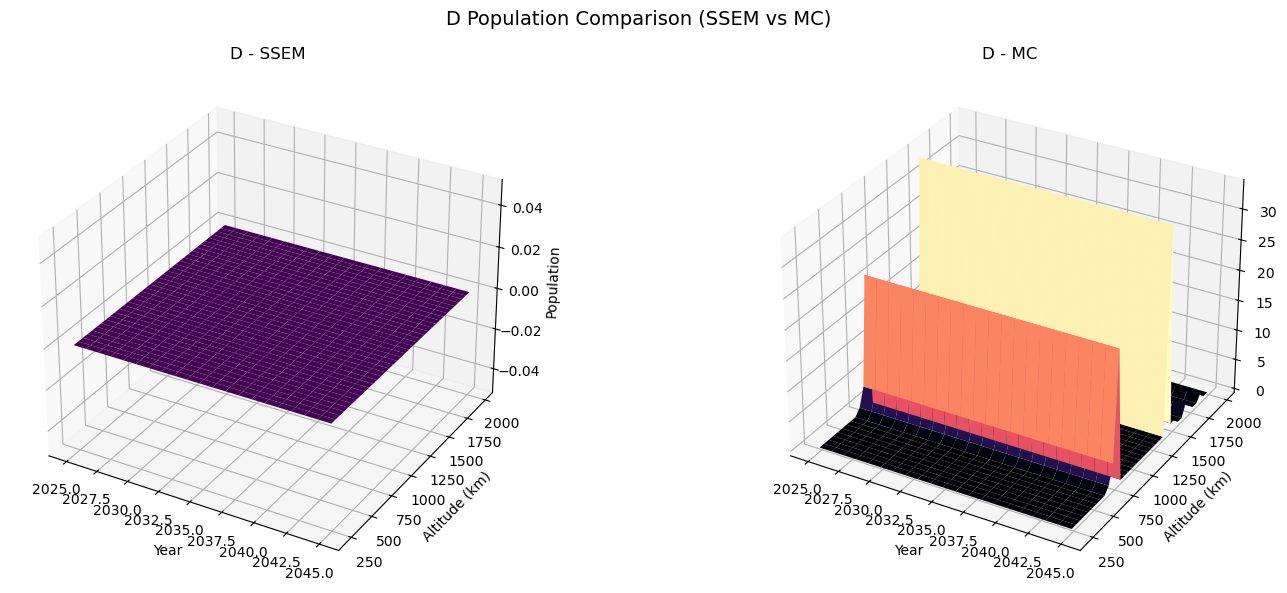

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# === Load data ===
ssem_path = "/Users/indigobrownhall/Code/pyssem/figures/SEP2/pop_time_alt.csv"

df_ssem = pd.read_csv(ssem_path)
df_mc = pd.read_csv(mc_pop_time_alt_path)

# Normalize species names
df_mc["Species"] = df_mc["Species"].replace({"SU": "Su", "SNS": "Sns"})

# List of species to compare
species_list = ['S', 'Su', 'Sns', 'B', 'N', 'D']

for sp in species_list:
    # Filter data
    df1 = df_ssem[df_ssem["Species"] == sp]
    df2 = df_mc[df_mc["Species"] == sp]

    # Pivot both into 2D matrices (Altitude × Year)
    pivot_ssem = df1.pivot_table(index="Altitude", columns="Year", values="Population", aggfunc='sum', fill_value=0)
    pivot_mc   = df2.pivot_table(index="Altitude", columns="Year", values="Population", aggfunc='sum', fill_value=0)

    # Align indexes and columns
    altitudes = sorted(set(pivot_ssem.index).union(pivot_mc.index))
    years     = sorted(set(pivot_ssem.columns).union(pivot_mc.columns))
    pivot_ssem = pivot_ssem.reindex(index=altitudes, columns=years, fill_value=0)
    pivot_mc   = pivot_mc.reindex(index=altitudes, columns=years, fill_value=0)

    X, Y = np.meshgrid(pivot_ssem.columns, pivot_ssem.index)

    # === Plot ===
    fig = plt.figure(figsize=(16, 6))
    
    # --- SSEM ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, pivot_ssem.values, cmap='viridis')
    ax1.set_title(f"{sp} - SSEM")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Altitude (km)")
    ax1.set_zlabel("Population")
    
    # --- MC ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, pivot_mc.values, cmap='magma')
    ax2.set_title(f"{sp} - MC")
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Altitude (km)")
    ax2.set_zlabel("Population")

    plt.suptitle(f"{sp} Population Comparison (SSEM vs MC)", fontsize=14)
    plt.tight_layout()
    plt.show()

In [12]:
print(sum(scenario_properties.FLM_steps.B))

print(grouped_trimmed.B.sum())

1171
1171
